# Bean Leaf Classification

Dataset público obtenido en Kaggle: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification

El conjunto de datos contiene fotografías de tres estados de lesión de hojas de leguminosas, incluidas 1034 imágenes en el conjunto de entrenamiento y 133 imágenes en el conjunto de calibración, con un tamaño de datos de 155 MB. Se admite el reconocimiento de los siguientes estados de lesión foliar: saludable, angular_leaf_spot y bean_rust.

### Setup

In [1]:
import os
import cv2
import tensorflow as tf
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
import matplotlib.image as mpimg
from tensorflow.keras import layers, models


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_images_from_folder(folder_path):
    folder = Path(folder_path)
    image_files = list(folder.glob('*.jpg'))  # Cambia el patrón según las extensiones de tus imágenes
    labels = [folder.name] * len(image_files)

    # Cargar las imágenes y las etiquetas
    images = [tf.io.read_file(str(img)) for img in image_files]
    labels = [tf.constant(label) for label in labels]

    return tf.data.Dataset.from_tensor_slices((images, labels))

## Carga de datos

Kaggle ya hace la separación de train y validation, por lo que ocuparemos su selección paras ser consistentes

In [3]:
# Definir las rutas de las carpetas
angular_leaf_spot_train_path = "bases/bean_leaf/train/angular_leaf_spot"
angular_leaf_spot_test_path = "bases/bean_leaf/val/angular_leaf_spot"

bean_rust_train_path = "bases/bean_leaf/train/bean_rust"
bean_rust_test_path = "bases/bean_leaf/val/bean_rust"

healthy_train_path = "bases/bean_leaf/train/healthy"
healthy_test_path = "bases/bean_leaf/val/healthy"


# Cargar imágenes desde diferentes carpetas
angular_leaf_spot_train_dataset = load_images_from_folder(angular_leaf_spot_train_path)
angular_leaf_spot_test_dataset = load_images_from_folder(angular_leaf_spot_test_path)

bean_rust_train_dataset = load_images_from_folder(bean_rust_train_path)
bean_rust_test_dataset = load_images_from_folder(bean_rust_test_path)

healthy_train_dataset = load_images_from_folder(healthy_train_path)
healthy_test_dataset = load_images_from_folder(healthy_test_path)

# Combinar los conjuntos de datos
train_dataset = angular_leaf_spot_train_dataset.concatenate(bean_rust_train_dataset)\
    .concatenate(healthy_train_dataset)

test_dataset = angular_leaf_spot_test_dataset.concatenate(bean_rust_test_dataset)\
    .concatenate(healthy_test_dataset)


2023-11-16 19:52:16.376898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Imprimir algunos ejemplos
for img, label in train_dataset.take(5):
    print(f"Label: {label.numpy()}, Image Shape: {tf.image.decode_image(img).shape}")

Label: b'angular_leaf_spot', Image Shape: (500, 500, 3)
Label: b'angular_leaf_spot', Image Shape: (500, 500, 3)
Label: b'angular_leaf_spot', Image Shape: (500, 500, 3)
Label: b'angular_leaf_spot', Image Shape: (500, 500, 3)
Label: b'angular_leaf_spot', Image Shape: (500, 500, 3)


## Data Augmentation

In [5]:
# Parámetros para el modelo y el data augmentation
input_shape = (224, 224, 3)  # Ajusta el tamaño según tus imágenes
batch_size = 32
epochs = 100

# Crea un generador de datos con data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Carga las imágenes desde las carpetas utilizando el generador de datos
train_generator = train_datagen.flow_from_directory(
    "bases/bean_leaf/train",
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'  # Ajusta esto según tu configuración de clases
)


validation_generator = test_datagen.flow_from_directory(
    "bases/bean_leaf/val",
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    "bases/bean_leaf/val",
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


## Modelo 1 tres capas convolucionales

### Arquitectura

In [57]:
# Construye el modelo CNN
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(3, activation='softmax'))  # Ajusta el número de clases según tu configuración

# Compila el modelo
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Ajusta la función de pérdida según tu problema
              metrics=['accuracy'])


# Entrena el modelo utilizando el generador de datos
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100
32/32 [==============================] - 31s 966ms/step - loss: 1.2289 - accuracy: 0.4172 - val_loss: 1.0262 - val_accuracy: 0.4766
Epoch 2/100
32/32 [==============================] - 30s 937ms/step - loss: 0.9124 - accuracy: 0.5659 - val_loss: 1.1873 - val_accuracy: 0.4922
Epoch 3/100
32/32 [==============================] - 32s 996ms/step - loss: 0.8628 - accuracy: 0.6048 - val_loss: 0.8152 - val_accuracy: 0.6406
Epoch 4/100
32/32 [==============================] - 34s 1s/step - loss: 0.7838 - accuracy: 0.6523 - val_loss: 0.6284 - val_accuracy: 0.7266
Epoch 5/100
32/32 [==============================] - 34s 1s/step - loss: 0.7359 - accuracy: 0.6737 - val_loss: 0.5472 - val_accuracy: 0.7656
Epoch 6/100
32/32 [==============================] - 34s 1s/step - loss: 0.6922 - accuracy: 0.7016 - val_loss: 0.5828 - val_accuracy: 0.7109
Epoch 7/100
32/32 [==============================] - 35s 1s/step - loss: 0.6544 - accuracy: 0.7236 - val_loss: 0.4683 - val_accuracy: 0.8516
Epoc

Epoch 59/100
32/32 [==============================] - 1010s 33s/step - loss: 0.2509 - accuracy: 0.9092 - val_loss: 0.3235 - val_accuracy: 0.9062
Epoch 60/100
32/32 [==============================] - 957s 31s/step - loss: 0.2241 - accuracy: 0.9072 - val_loss: 0.2040 - val_accuracy: 0.9375
Epoch 61/100
32/32 [==============================] - 950s 31s/step - loss: 0.2039 - accuracy: 0.9152 - val_loss: 0.3054 - val_accuracy: 0.9141
Epoch 62/100
32/32 [==============================] - 1080s 35s/step - loss: 0.2029 - accuracy: 0.9232 - val_loss: 0.3066 - val_accuracy: 0.8828
Epoch 63/100
32/32 [==============================] - 29s 890ms/step - loss: 0.2474 - accuracy: 0.9052 - val_loss: 0.2390 - val_accuracy: 0.9219
Epoch 64/100
32/32 [==============================] - 189s 6s/step - loss: 0.2123 - accuracy: 0.9162 - val_loss: 0.2467 - val_accuracy: 0.9219
Epoch 65/100
32/32 [==============================] - 960s 31s/step - loss: 0.2108 - accuracy: 0.9132 - val_loss: 0.2156 - val_accurac

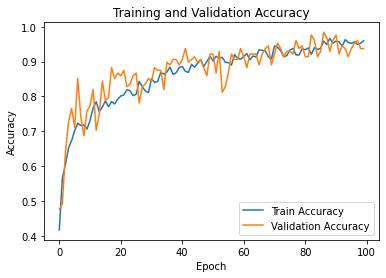

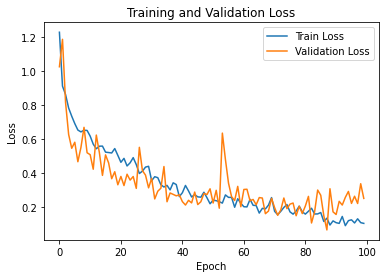

In [58]:
# Grafica del accuracy
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Grafica la pérdida
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

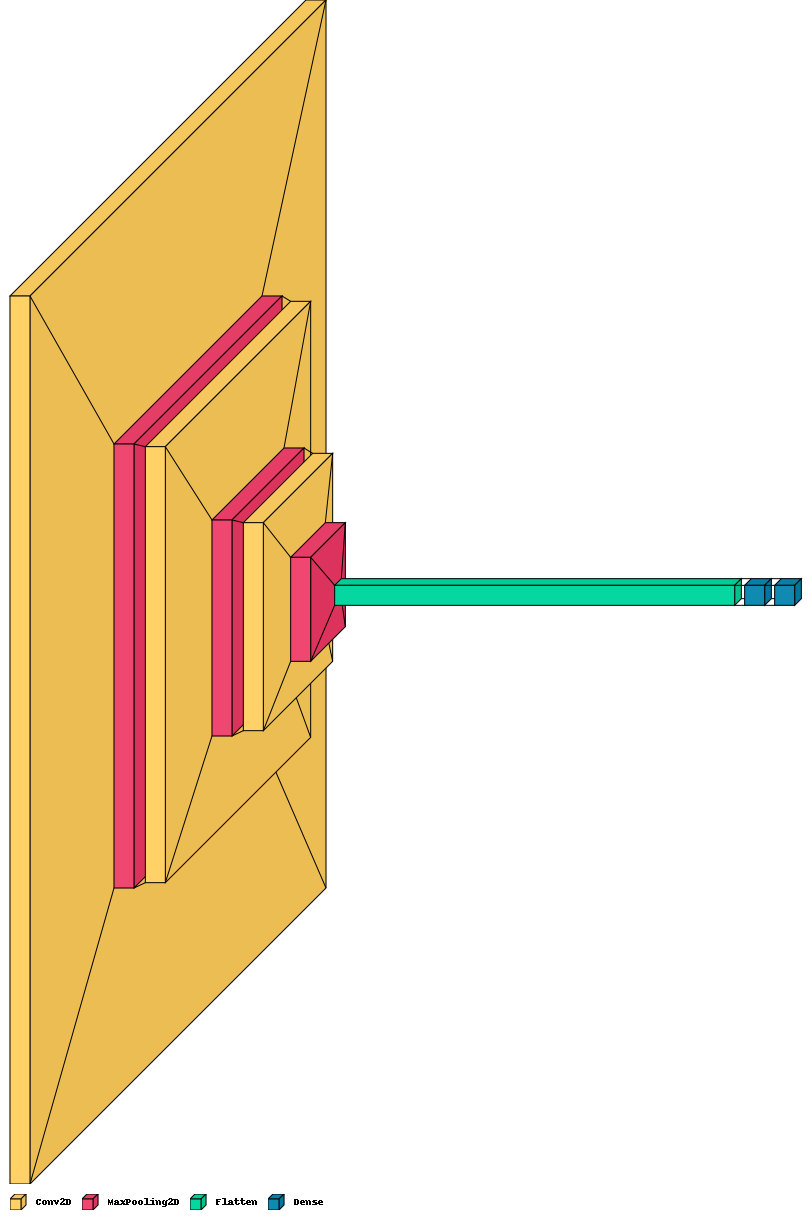

In [59]:
import visualkeras
visualkeras.layered_view(model1, legend=True)

### Resultados

In [60]:
test_generator = test_datagen.flow_from_directory(
    "bases/bean_leaf/val",
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

# Calcula la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = model1.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 133 images belonging to 3 classes.
4/4 [==============================] - 2s 344ms/step - loss: 0.2555 - accuracy: 0.9375
Test Accuracy: 93.75%


5/5 [==============================] - 2s 265ms/step


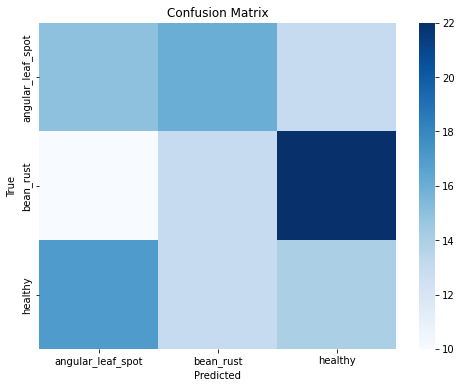

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.36      0.34      0.35        44
        bean_rust       0.31      0.29      0.30        45
          healthy       0.29      0.32      0.30        44

         accuracy                           0.32       133
        macro avg       0.32      0.32      0.32       133
     weighted avg       0.32      0.32      0.32       133



In [61]:
predictions = model1.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Obtén las etiquetas reales del conjunto de prueba
true_labels = test_generator.classes

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualiza la matriz de confusión como un heatmap
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Muestra el informe de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

## Bean production visualization

In [2]:
import pandas as pd
bean_prod = pd.read_csv('bases/bean_production.csv')
bean_prod

,Entity,Code,Year,"Beans, dry | 00000176 || Production | 005510 || tonnes"
0,Africa,NaN,1961,1015116.00
1,Africa,NaN,1962,1015200.00
2,Africa,NaN,1963,1034416.00
3,Africa,NaN,1964,1065483.00
4,Africa,NaN,1965,1078757.00
...,...,...,...,...
9264,Zimbabwe,ZWE,2017,15262.00
9265,Zimbabwe,ZWE,2018,22108.00
9266,Zimbabwe,ZWE,2019,6399.04
9267,Zimbabwe,ZWE,2020,15867.00


## Modelo 2 Lenet5


### Arquitectura

In [15]:
# Carga las imágenes desde las carpetas utilizando el generador de datos
train_lenet_generator = train_datagen.flow_from_directory(
    "bases/bean_leaf/train",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical'  # Ajusta esto según tu configuración de clases
)

validation_lenet_generator = test_datagen.flow_from_directory(
    "bases/bean_leaf/val",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


In [16]:
# Construye el modelo LeNet
model2 = models.Sequential()
model2.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(16, (5, 5), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(120, activation='relu'))
model2.add(layers.Dense(84, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))  # Ajusta el número de clases según tu configuración



# Compila el modelo
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Ajusta la función de pérdida según tu problema
              metrics=['accuracy'])


# Entrena el modelo utilizando el generador de datos
history2 = model2.fit(
    train_lenet_generator,
    steps_per_epoch=train_lenet_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_lenet_generator,
    validation_steps=validation_lenet_generator.samples // batch_size
)

Epoch 1/100
32/32 [==============================] - 5s 149ms/step - loss: 1.0722 - accuracy: 0.3992 - val_loss: 1.0206 - val_accuracy: 0.4688
Epoch 2/100
32/32 [==============================] - 5s 144ms/step - loss: 0.9793 - accuracy: 0.5030 - val_loss: 0.8903 - val_accuracy: 0.5781
Epoch 3/100
32/32 [==============================] - 4s 137ms/step - loss: 0.9013 - accuracy: 0.5938 - val_loss: 0.7972 - val_accuracy: 0.6250
Epoch 4/100
32/32 [==============================] - 4s 136ms/step - loss: 0.9203 - accuracy: 0.5539 - val_loss: 0.9266 - val_accuracy: 0.5078
Epoch 5/100
32/32 [==============================] - 4s 132ms/step - loss: 0.8671 - accuracy: 0.6058 - val_loss: 0.8118 - val_accuracy: 0.5781
Epoch 6/100
32/32 [==============================] - 4s 132ms/step - loss: 0.8127 - accuracy: 0.6377 - val_loss: 0.7328 - val_accuracy: 0.6562
Epoch 7/100
32/32 [==============================] - 4s 132ms/step - loss: 0.8096 - accuracy: 0.6387 - val_loss: 0.9585 - val_accuracy: 0.5625

Epoch 58/100
32/32 [==============================] - 4s 121ms/step - loss: 0.6323 - accuracy: 0.7236 - val_loss: 0.6946 - val_accuracy: 0.6797
Epoch 59/100
32/32 [==============================] - 4s 124ms/step - loss: 0.5486 - accuracy: 0.7744 - val_loss: 0.6943 - val_accuracy: 0.7188
Epoch 60/100
32/32 [==============================] - 4s 121ms/step - loss: 0.5449 - accuracy: 0.7695 - val_loss: 1.1464 - val_accuracy: 0.6094
Epoch 61/100
32/32 [==============================] - 4s 121ms/step - loss: 0.5640 - accuracy: 0.7705 - val_loss: 0.7357 - val_accuracy: 0.6719
Epoch 62/100
32/32 [==============================] - 4s 121ms/step - loss: 0.5583 - accuracy: 0.7585 - val_loss: 0.6379 - val_accuracy: 0.7109
Epoch 63/100
32/32 [==============================] - 4s 121ms/step - loss: 0.5776 - accuracy: 0.7505 - val_loss: 0.7685 - val_accuracy: 0.6875
Epoch 64/100
32/32 [==============================] - 4s 121ms/step - loss: 0.5491 - accuracy: 0.7635 - val_loss: 0.9643 - val_accuracy:

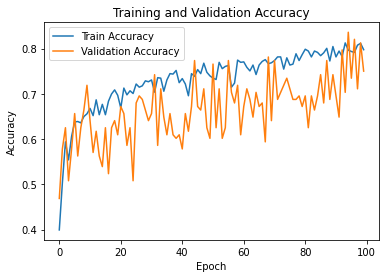

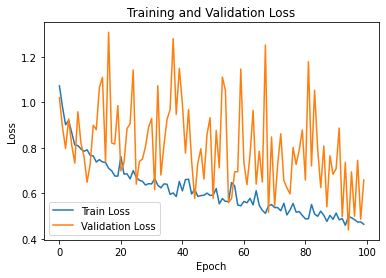

In [17]:
# Grafica del accuracy
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Grafica la pérdida
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

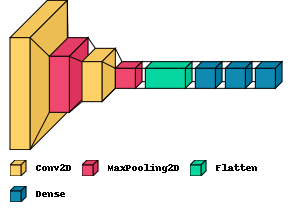

In [18]:
import visualkeras
visualkeras.layered_view(model2, legend=True)

### Resultados

In [19]:
# Evalúa el modelo en el conjunto de prueba
test_lenet_generator = test_datagen.flow_from_directory(
    "bases/bean_leaf/val",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical'
)

# Calcula la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = model2.evaluate(
    test_lenet_generator,
    steps=test_lenet_generator.samples // batch_size
)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 133 images belonging to 3 classes.
4/4 [==============================] - 0s 100ms/step - loss: 0.6535 - accuracy: 0.7500
Test Accuracy: 75.00%


5/5 [==============================] - 0s 78ms/step


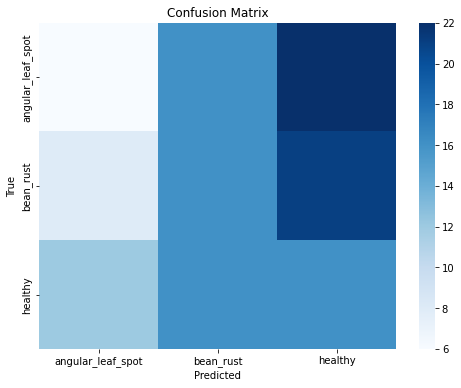

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.23      0.14      0.17        44
        bean_rust       0.33      0.36      0.34        45
          healthy       0.27      0.36      0.31        44

         accuracy                           0.29       133
        macro avg       0.28      0.29      0.28       133
     weighted avg       0.28      0.29      0.28       133



In [20]:
predictions = model2.predict(test_lenet_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Obtén las etiquetas reales del conjunto de prueba
true_labels = test_generator.classes

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualiza la matriz de confusión como un heatmap
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Muestra el informe de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

## Modelo 3 Transfer learning ResNet50

### Arquitectura

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [51]:
# Cargar el modelo preentrenado ResNet50 sin las capas densas (top)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas adicionales al modelo
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)

# Construir el modelo completo
model3 = Model(inputs=base_model.input, outputs=x)


# Compilar el modelo
model3.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Visualizar la arquitectura del modelo
display(model3.summary())


train_resnet_generator = train_datagen.flow_from_directory(
    "bases/bean_leaf/train",
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_resnet_generator = test_datagen.flow_from_directory(
    "bases/bean_leaf/val",
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_resnet_generator = test_datagen.flow_from_directory(
    "bases/bean_leaf/val",
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


In [52]:
# Definir callbacks (opcional)
checkpoint = ModelCheckpoint("bean_leaf_transfer_learning.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Entrenar el modelo
history3 = model3.fit(
    train_resnet_generator,
    steps_per_epoch=train_resnet_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_resnet_generator,
    validation_steps=validation_resnet_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.3224 - accuracy: 0.3323
Epoch 1: val_accuracy improved from -inf to 0.32812, saving model to bean_leaf_transfer_learning.h5
32/32 [==============================] - 88s 3s/step - loss: 1.3224 - accuracy: 0.3323 - val_loss: 1.0982 - val_accuracy: 0.3281
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.3533
Epoch 2: val_accuracy did not improve from 0.32812
32/32 [==============================] - 86s 3s/step - loss: 1.1269 - accuracy: 0.3533 - val_loss: 1.0965 - val_accuracy: 0.3281
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 1.1135 - accuracy: 0.3533
Epoch 3: val_accuracy improved from 0.32812 to 0.33594, saving model to bean_leaf_transfer_learning.h5
32/32 [==============================] - 86s 3s/step - loss: 1.1135 - accuracy: 0.3533 - val_loss: 1.0976 - val_accuracy: 0.3359
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.112

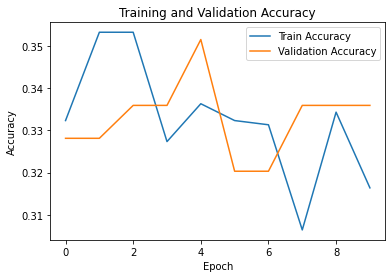

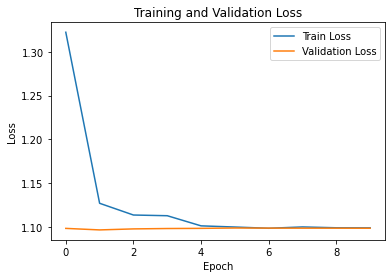

In [53]:
# Grafica del accuracy
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Grafica la pérdida
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

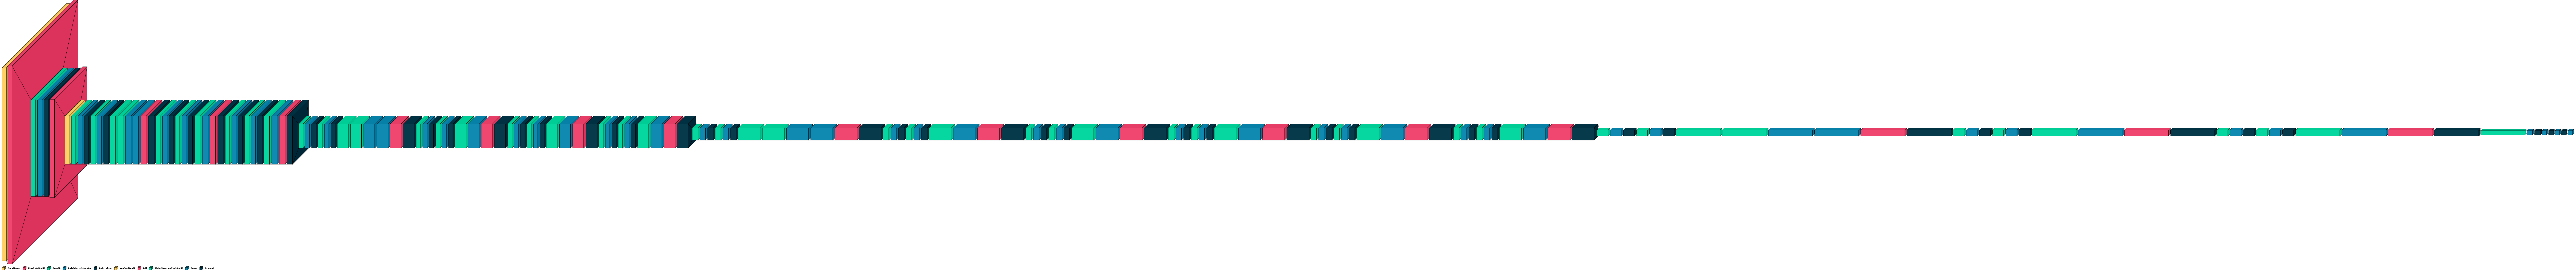

In [54]:
import visualkeras
visualkeras.layered_view(model3, legend=True)

### Resultados

In [55]:
# Calcula la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = model3.evaluate(
    test_resnet_generator,
    steps=test_resnet_generator.samples // batch_size
)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 9s 2s/step - loss: 1.0982 - accuracy: 0.3516
Test Accuracy: 35.16%


5/5 [==============================] - 10s 2s/step


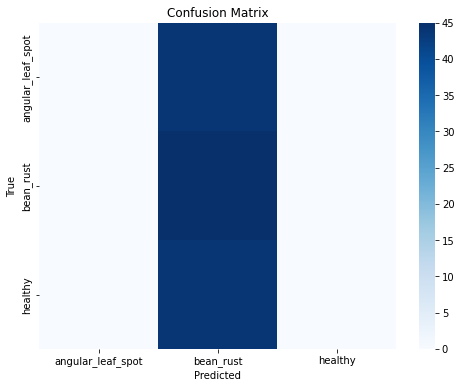

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.00      0.00      0.00        44
        bean_rust       0.34      1.00      0.51        45
          healthy       0.00      0.00      0.00        44

         accuracy                           0.34       133
        macro avg       0.11      0.33      0.17       133
     weighted avg       0.11      0.34      0.17       133



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
predictions = model3.predict(test_resnet_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Obtén las etiquetas reales del conjunto de prueba
true_labels = test_generator.classes

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualiza la matriz de confusión como un heatmap
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Muestra el informe de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

## Transfer Learning Resnet, DensNet, EfficentNet

In [36]:
input_shape_resnet = (224, 224, 3)
input_shape_densenet = (224, 224, 3)
input_shape_efficientnet = (224, 224, 3)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-7)

# Load pre-trained ResNet50 model and remove the top classification layer
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_resnet)
resnet_base_model.trainable = False

# Add custom classification head to the ResNet model
resnet_global_avg_pooling = GlobalAveragePooling2D()(resnet_base_model.output)
resnet_output = Dense(6, activation='softmax')(resnet_global_avg_pooling)
resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_output)

# Compile the ResNet model
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

resnet_history = resnet_model.fit(train_resnet_generator, 
                                  batch_size=32, epochs=epochs, 
                                  validation_data=validation_resnet_generator,
                                  callbacks=[early_stopping, lr_scheduler])


## Modelo 4 Transfer learning resnet 50 2

### Arquitectura

In [39]:
# Load pre-trained ResNet50 model and remove the top classification layer
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_resnet)
resnet_base_model.trainable = False

# Add custom classification head to the ResNet model
resnet_global_avg_pooling = GlobalAveragePooling2D()(resnet_base_model.output)
resnet_output = Dense(3, activation='softmax')(resnet_global_avg_pooling)
resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_output)

# Compile the ResNet model
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
resnet_history = resnet_model.fit(train_resnet_generator, 
                                  batch_size=32, epochs=epochs, 
                                  validation_data=validation_resnet_generator,
                                  callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
33/33 [==============================] - 72s 2s/step - loss: 1.1116 - accuracy: 0.3395 - val_loss: 1.1228 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 80s 2s/step - loss: 1.1025 - accuracy: 0.3549 - val_loss: 1.1274 - val_accuracy: 0.3383 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 10171s 285s/step - loss: 1.1056 - accuracy: 0.3540 - val_loss: 1.0804 - val_accuracy: 0.3910 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 13209s 382s/step - loss: 1.0900 - accuracy: 0.3617 - val_loss: 1.0761 - val_accuracy: 0.3910 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 9172s 265s/step - loss: 1.0800 - accuracy: 0.4091 - val_loss: 1.0608 - val_accuracy: 0.4436 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 69s 2s/step - loss: 1.0791 - accuracy: 0.3965 - val_loss: 1.0789 - val_accuracy: 0.3609 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 75s 2s/st

Epoch 54/100
33/33 [==============================] - 87s 3s/step - loss: 0.9954 - accuracy: 0.5145 - val_loss: 1.0146 - val_accuracy: 0.4962 - lr: 0.0010
Epoch 55/100
33/33 [==============================] - 87s 3s/step - loss: 1.0005 - accuracy: 0.5068 - val_loss: 1.0146 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 56/100
33/33 [==============================] - 86s 3s/step - loss: 1.0018 - accuracy: 0.5174 - val_loss: 1.0047 - val_accuracy: 0.5113 - lr: 0.0010
Epoch 57/100
33/33 [==============================] - 86s 3s/step - loss: 0.9883 - accuracy: 0.5203 - val_loss: 0.9902 - val_accuracy: 0.5714 - lr: 5.0000e-04
Epoch 58/100
33/33 [==============================] - 87s 3s/step - loss: 1.0039 - accuracy: 0.5087 - val_loss: 1.0175 - val_accuracy: 0.5188 - lr: 5.0000e-04
Epoch 59/100
33/33 [==============================] - 87s 3s/step - loss: 1.0046 - accuracy: 0.5232 - val_loss: 1.0066 - val_accuracy: 0.5338 - lr: 5.0000e-04
Epoch 60/100
33/33 [==============================] - 87s 

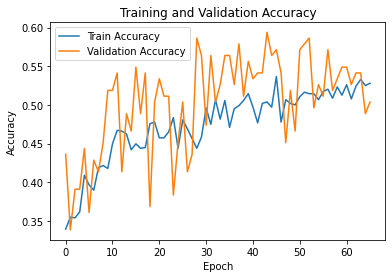

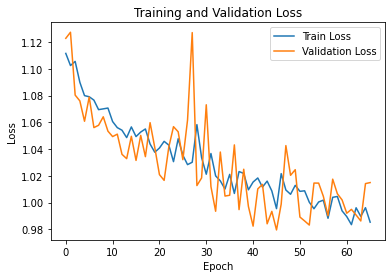

In [41]:
# Grafica del accuracy
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Grafica la pérdida
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

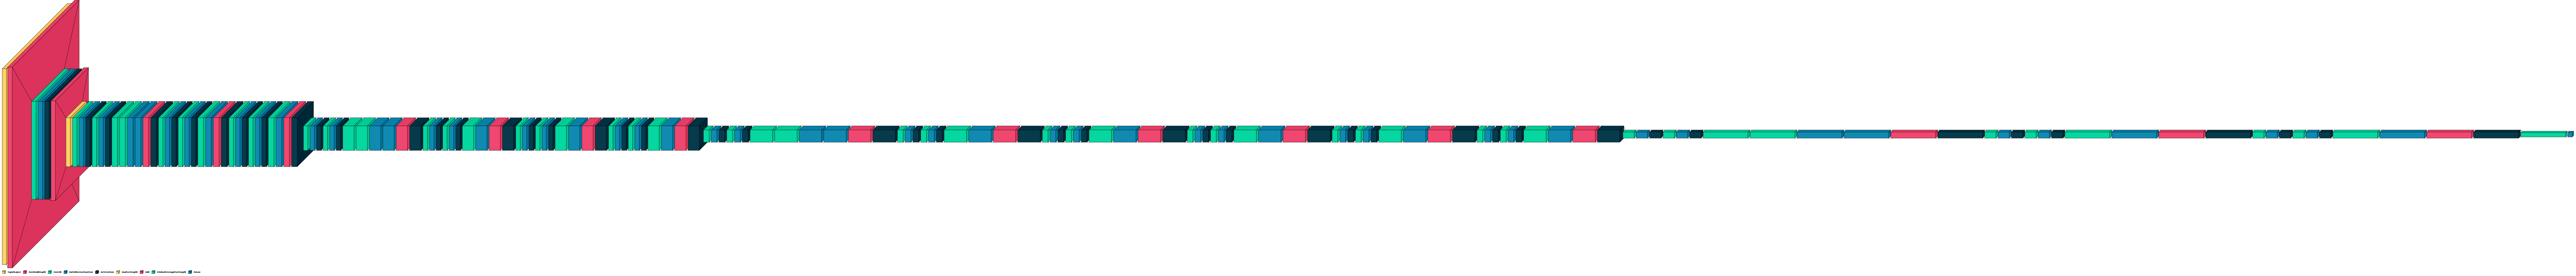

In [42]:
import visualkeras
visualkeras.layered_view(resnet_model, legend=True)

### Resultados

In [43]:
# Calcula la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = resnet_model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 9s 2s/step - loss: 0.9727 - accuracy: 0.5781
Test Accuracy: 57.81%


5/5 [==============================] - 10s 2s/step


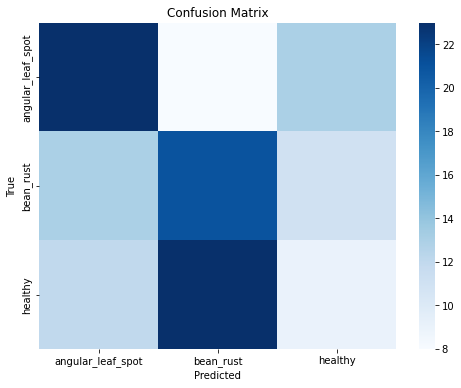

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.48      0.52      0.50        44
        bean_rust       0.40      0.47      0.43        45
          healthy       0.27      0.20      0.23        44

         accuracy                           0.40       133
        macro avg       0.39      0.40      0.39       133
     weighted avg       0.39      0.40      0.39       133



In [44]:
predictions = resnet_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Obtén las etiquetas reales del conjunto de prueba
true_labels = test_generator.classes

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualiza la matriz de confusión como un heatmap
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Muestra el informe de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

## Modelo 5 DenseNet

### Arquitectura

In [45]:
densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape_densenet)
densenet_base_model.trainable = False


densenet_global_avg_pooling = GlobalAveragePooling2D()(densenet_base_model.output)
densenet_output = Dense(3, activation='softmax')(densenet_global_avg_pooling)
densenet_model = Model(inputs=densenet_base_model.input, outputs=densenet_output)


densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
densenet_history = densenet_model.fit(train_resnet_generator, 
                                  batch_size=32, epochs=epochs, 
                                  validation_data=validation_resnet_generator,
                                  callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
33/33 [==============================] - 77s 2s/step - loss: 1.0633 - accuracy: 0.4613 - val_loss: 0.9015 - val_accuracy: 0.5414 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 75s 2s/step - loss: 0.7777 - accuracy: 0.6509 - val_loss: 0.6487 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 75s 2s/step - loss: 0.6464 - accuracy: 0.7427 - val_loss: 0.5562 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 74s 2s/step - loss: 0.5642 - accuracy: 0.7785 - val_loss: 0.5073 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 74s 2s/step - loss: 0.5116 - accuracy: 0.7863 - val_loss: 0.4724 - val_accuracy: 0.8271 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 74s 2s/step - loss: 0.4731 - accuracy: 0.8279 - val_loss: 0.4264 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 74s 2s/step - loss: 0.4

Epoch 54/100
33/33 [==============================] - 75s 2s/step - loss: 0.2091 - accuracy: 0.9197 - val_loss: 0.2039 - val_accuracy: 0.9248 - lr: 5.0000e-04
Epoch 55/100
33/33 [==============================] - 75s 2s/step - loss: 0.1763 - accuracy: 0.9478 - val_loss: 0.2002 - val_accuracy: 0.9323 - lr: 5.0000e-04
Epoch 56/100
33/33 [==============================] - 81s 2s/step - loss: 0.2081 - accuracy: 0.9217 - val_loss: 0.2055 - val_accuracy: 0.9248 - lr: 5.0000e-04
Epoch 57/100
33/33 [==============================] - 75s 2s/step - loss: 0.1994 - accuracy: 0.9246 - val_loss: 0.2337 - val_accuracy: 0.8947 - lr: 5.0000e-04
Epoch 58/100
33/33 [==============================] - 75s 2s/step - loss: 0.2009 - accuracy: 0.9246 - val_loss: 0.2408 - val_accuracy: 0.9023 - lr: 5.0000e-04
Epoch 59/100
33/33 [==============================] - 75s 2s/step - loss: 0.2036 - accuracy: 0.9226 - val_loss: 0.2142 - val_accuracy: 0.9248 - lr: 5.0000e-04
Epoch 60/100
33/33 [==========================

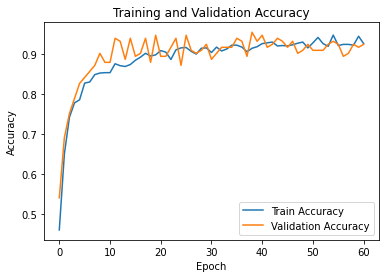

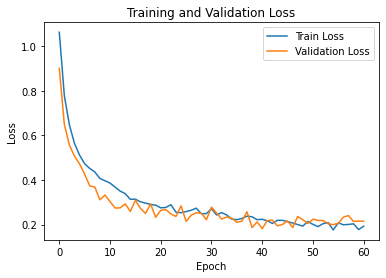

In [47]:
# Grafica del accuracy
plt.plot(densenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(densenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Grafica la pérdida
plt.plot(densenet_history.history['loss'], label='Train Loss')
plt.plot(densenet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

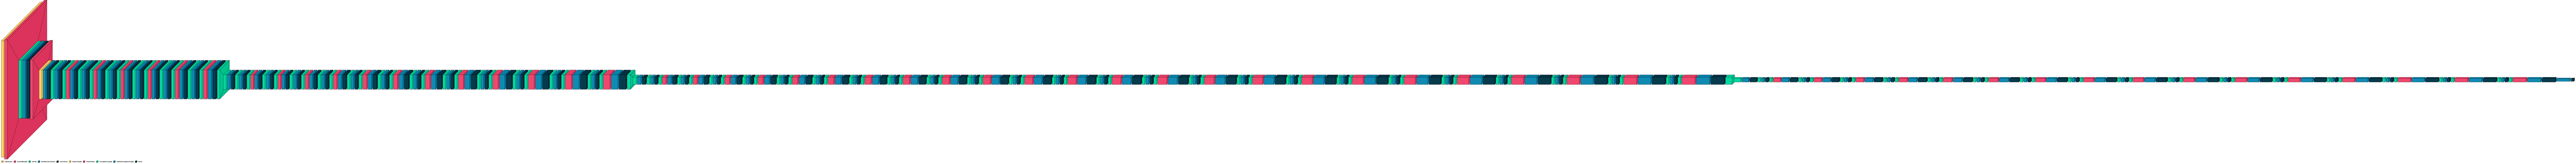

In [48]:
import visualkeras
visualkeras.layered_view(densenet_model, legend=True)

### Resultados

In [49]:
# Calcula la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = densenet_model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 8s 2s/step - loss: 0.1850 - accuracy: 0.9453
Test Accuracy: 94.53%


5/5 [==============================] - 9s 2s/step


array([[14, 14, 16],
       [12, 18, 15],
       [12, 16, 16]])

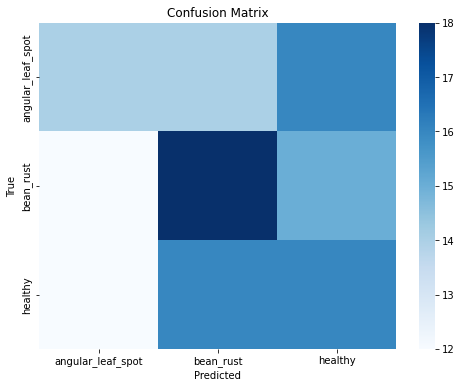

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.37      0.32      0.34        44
        bean_rust       0.38      0.40      0.39        45
          healthy       0.34      0.36      0.35        44

         accuracy                           0.36       133
        macro avg       0.36      0.36      0.36       133
     weighted avg       0.36      0.36      0.36       133



In [50]:
predictions = densenet_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Obtén las etiquetas reales del conjunto de prueba
true_labels = test_generator.classes

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
display(conf_matrix)

# Visualiza la matriz de confusión como un heatmap
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Muestra el informe de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

## Model 6 DenseNet Fine tuning

### Arquitectura

In [62]:
for layer in densenet_base_model.layers[-10:]:
    layer.trainable = True
    
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [63]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math

# Fine-tuning de las últimas 10 capas
for layer in densenet_base_model.layers[-10:]:
    layer.trainable = True

# Aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning Rate Schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Compilación del modelo
densenet_model_ft = densenet_model
densenet_model_ft.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history6 = densenet_model_ft.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[lr_scheduler]
)

Epoch 1/100
32/32 [==============================] - 54s 2s/step - loss: 0.2723 - accuracy: 0.8922 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 55s 2s/step - loss: 0.2082 - accuracy: 0.9162 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 57s 2s/step - loss: 0.1788 - accuracy: 0.9321 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 58s 2s/step - loss: 0.1532 - accuracy: 0.9491 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 58s 2s/step - loss: 0.1487 - accuracy: 0.9501 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 59s 2s/step - loss: 0.1219 - accuracy: 0.9501 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 59s 2s/step - loss: 0.1154 - accuracy: 0.9571 - lr: 0.0010
Epoch 8/100
32/32 [==============================] - 60s 2s/step - loss: 0.1049 - accuracy: 0.9601 - lr: 0.0010
Epoch 9/100
32/32 [==============================] - 214s 7s/step - loss: 0.0981 - accuracy: 0.9621 - lr

KeyError: 'val_accuracy'

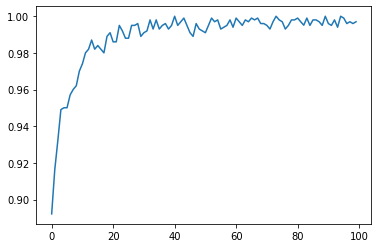

In [64]:
# Grafica del accuracy
plt.plot(history6.history['accuracy'], label='Train Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Grafica la pérdida
plt.plot(history6.history['loss'], label='Train Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

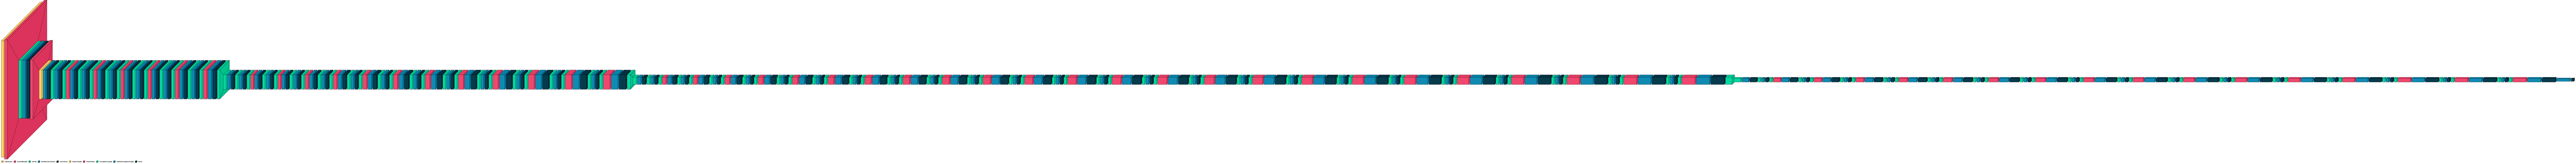

In [65]:
import visualkeras
visualkeras.layered_view(densenet_model_ft, legend=True)

### Resultados

In [66]:
# Calcula la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = densenet_model_ft.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 7s 1s/step - loss: 0.1291 - accuracy: 0.9609
Test Accuracy: 96.09%


5/5 [==============================] - 7s 1s/step


array([[17, 11, 16],
       [11, 19, 15],
       [11, 19, 14]])

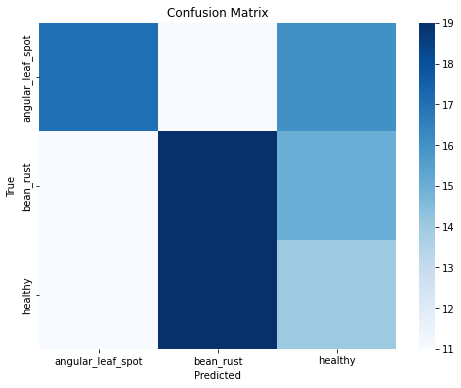

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.44      0.39      0.41        44
        bean_rust       0.39      0.42      0.40        45
          healthy       0.31      0.32      0.31        44

         accuracy                           0.38       133
        macro avg       0.38      0.38      0.38       133
     weighted avg       0.38      0.38      0.38       133



In [68]:
predictions = densenet_model_ft.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Obtén las etiquetas reales del conjunto de prueba
true_labels = test_generator.classes

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
display(conf_matrix)

# Visualiza la matriz de confusión como un heatmap
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Muestra el informe de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))